In [1]:
# conda activate aso_design
import sys
from pathlib import Path

p = Path.cwd()
while p != p.parent and not (p / "pyproject.toml").exists():
    p = p.parent

sys.path.insert(0, str(p))
print("Project root:", p)



import pandas as pd
from notebooks.consts import *
from tauso.file_utils import read_human_genome_fasta_dict
from tauso.consts import *
import numpy as np
from tauso.util import get_antisense
import pickle
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.file_utils import read_human_genome_fasta_dict
import RNA

Project root: /home/nivd1/TAUSO


In [2]:
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

Preprocessing ASO Experimental Dataset

In [3]:
from notebooks.notebook_utils import log_correction

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan) # to avoid log 0

In [4]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')






In [5]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

In [6]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [7]:
all_data_human_gene.columns

Index(['index', 'ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'Transcript', 'Location_in_sequence',
       'Location_div_by_length', 'true_length_of_seq', 'mod_scan',
       'cell_line_uniform', 'log_inhibition', 'sense_sequence',
       'pre_mrna_sequence', 'sense_start', 'sense_length'],
      dtype='object')

In [8]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,41212.0,0.901972,16,0,A431,-4.204842,TAGCATTTGTTTTAGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41212,16
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,23686.0,0.518395,16,0,A431,-4.532707,GATATTCACCATTATA,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23686,16
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,43363.0,0.949049,16,1,A431,-3.637849,CCAGAAATCTTCATGC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,43363,16
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,23680.0,0.518264,16,0,A431,-4.276805,TTTGAAGATATTCACC,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,23680,16
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,41168.0,0.901009,16,0,A431,-4.159039,CATACTAGTACAAGTG,GATTTTCCTAGGCGGCGGCCGCGGCGGCGGAGGCAGCAGCGGCGGC...,41168,16


In [9]:
from src.tauso.genome.read_human_genome import get_locus_to_data_dict

gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=set(genes_u))
g = next(iter(gene_to_data.keys()))
li = gene_to_data[g]

print("Example gene:", g)
print("Type:", type(li))
print("Dir:", [a for a in dir(li) if not a.startswith("_")][:50])

if isinstance(li, dict):
    print("Keys:", li.keys())


Elapsed DB:  0.002341747283935547
Elapsed Fasta:  0.002341747283935547
Length:  3099750718
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  start_codon
Feature type:  start_codon
Feature type:  transcript
Feature type:  CDS
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  transcript
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Feature type:  CDS
Fe

In [10]:
data_with_features = all_data_human_gene.copy()

In [11]:
from src.tauso.features.RNaseH_features import check_motif_presence
# motif presence
RNeseH1_motif_features = []
motif_list = ['TCCC', 'GGGA', 'CGCG', 'AGGA', 'TGCC' , 'CCCG' ,'TTTT', 'AAAA', 'CCCC', 'GGGG', 'TTAA', 'GCGC']
for motif in motif_list:
    data_with_features[f'RNaseH1_motif_presence_{motif}'] = data_with_features['Sequence'].apply(lambda x: check_motif_presence(x, motif))
    RNeseH1_motif_features.append(f'RNaseH1_motif_presence_{motif}')

In [12]:
from src.tauso.features.RNaseH_features import add_rnaseh1_scores_best_window_nt

all_data_human_gene, RNaseH1_features_best = add_rnaseh1_scores_best_window_nt(all_data_human_gene)


In [13]:
from src.tauso.features.RNaseH_features import add_rnaseh1_scores_best_window_dinuc

all_data_human_gene, RNaseH1_dinucleotide_features_best = add_rnaseh1_scores_best_window_dinuc(all_data_human_gene)


In [14]:
from src.tauso.features.RNaseH_features import add_rnaseh1_scores_best_window_krel_nt

all_data_human_gene, RNaseH1_Krel_features_best = add_rnaseh1_scores_best_window_krel_nt(all_data_human_gene)


In [15]:
from src.tauso.features.RNaseH_features import add_rnaseh1_scores_best_window_krel_dinuc

all_data_human_gene, RNaseH1_Krel_dinucleotide_features_best = add_rnaseh1_scores_best_window_krel_dinuc(all_data_human_gene)


Check correlations

In [16]:
from notebooks.features.RNaseH.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(all_data_human_gene, target='log_inhibition')
display(results_df)

,Feature,Pearson,Spearman,NMI_max
16,Inhibition(%),0.891,1.000,2.056
1,ISIS,-0.092,-0.145,0.154
0,index,0.317,0.301,0.114
28,sense_start,-0.018,0.219,0.107
21,Location_in_sequence,-0.013,0.223,0.106
6,ASO_volume(nM),0.288,0.296,0.089
22,Location_div_by_length,0.084,0.129,0.045
7,Treatment_Period(hours),-0.132,-0.266,0.032
32,RNaseH1_score_R7,0.038,0.035,0.025
40,RNaseH1_Krel_dinucleotide_score_R4b_krel_dinuc,-0.047,-0.055,0.025


In [17]:
from notebooks.features.RNaseH.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_motif_presence')

No features found starting with 'RNaseH1_motif_presence'


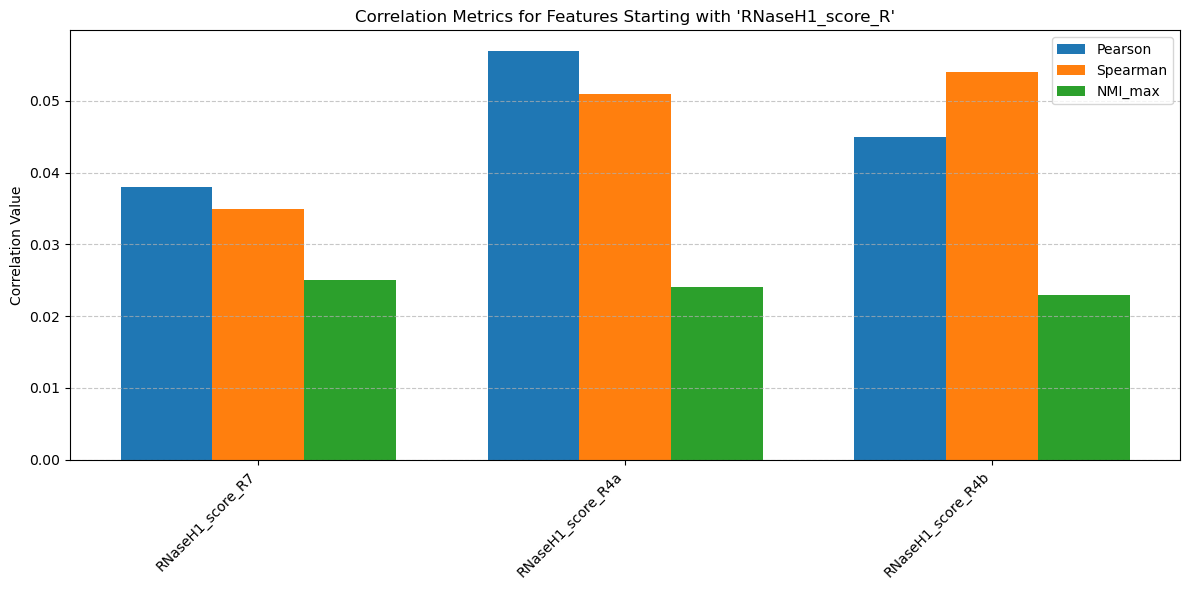

In [18]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_score_R')


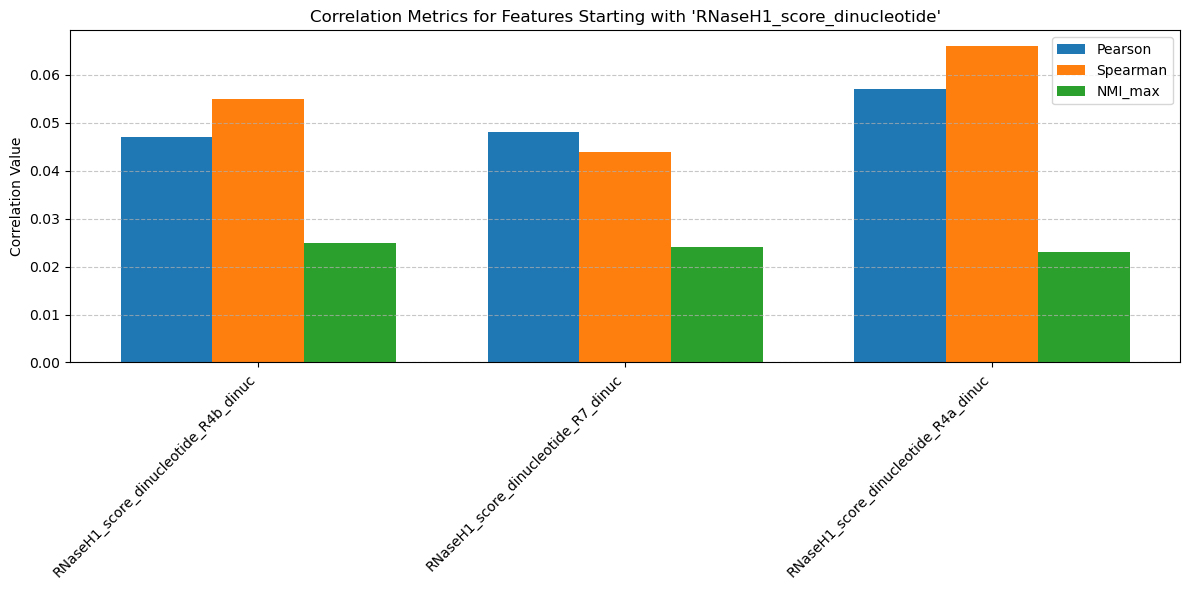

In [19]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_score_dinucleotide')


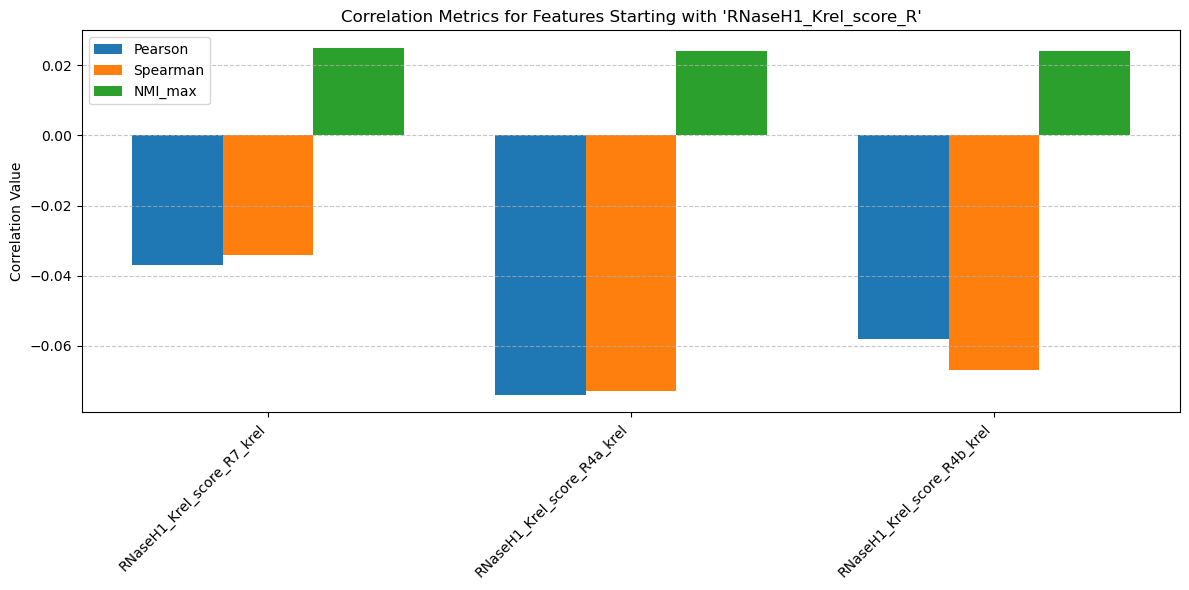

In [20]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_Krel_score_R')

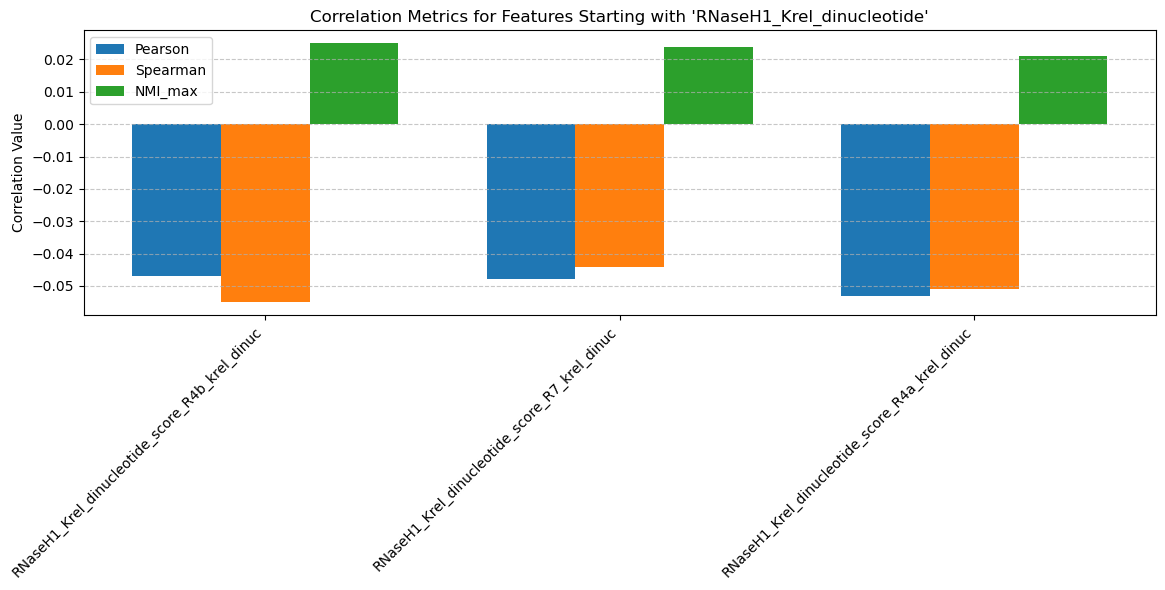

In [21]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_Krel_dinucleotide')

 Save DataFrame as CSV in the current working directory

In [22]:
"""""
from scripts.features.feature_extraction import save_feature
for feat in RNaseH1_best_features_list:
    save_feature(filtered, feat)

"""


'""\nfrom scripts.features.feature_extraction import save_feature\nfor feat in RNaseH1_best_features_list:\n    save_feature(filtered, feat)\n\n'